In [12]:
import warnings
from itertools import product
import glob
from datetime import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.feature as cf
import shapely.geometry as sgeom
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


from sklearn.decomposition import PCA
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.metrics import davies_bouldin_score

import pickle
import copy
from shapely import geometry
from sklearn.metrics.pairwise import euclidean_distances
import statsmodels.api as sm
from scipy.stats import linregress
from sklearn.metrics import accuracy_score
import math
import matplotlib.lines as mlines
from scipy.stats import ks_2samp

In [13]:
names_reanalyses = ['ERA5',
                   'JRA3Q',
                   'NCEP_NCAR']

In [14]:
dic_labels = {}
for reanalysis in names_reanalyses:
    labels_temp = pd.read_csv(f'../Data_v3/Labels/df_labels_{reanalysis}_v3.csv', 
                              parse_dates=True, index_col=0, names=['WR','distance'], skiprows=1)
    labels_temp['season'] = labels_temp.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    labels_temp['season'] = labels_temp['season'].map(season_map)
    dic_labels[reanalysis] = labels_temp


dic_events = {}

for ir, reanalysis in enumerate(names_reanalyses):
    # Compute Overall Frequency of Each Class
    df_labels = copy.deepcopy(dic_labels[reanalysis])
    df_labels['season'] = df_labels.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    df_labels['season'] = df_labels['season'].map(season_map)
    
    # Step 1: Identify changes in class to find the start of each event
    df_labels['shifted'] = df_labels['WR'].shift(1)
    df_labels['start'] = df_labels['WR'] != df_labels['shifted']
    df_labels['start_date'] = df_labels.index.where(df_labels['start'], pd.NaT)
    df_labels['start_date'].fillna(method='ffill', inplace=True)
    
    # Step 2: Calculate the duration of each event
    # Convert the Timedelta to its 'days' component
    df_labels['duration'] = (df_labels.index - df_labels['start_date']).dt.days + 1
    
    # Step 3: Create the df_events DataFrame
    # Group by 'start_date' and 'class' to get the duration of each class event
    df_events = df_labels.groupby(['start_date', 'WR']).agg({'duration': 'max'}).reset_index()
    
    # Drop the temporary columns used for calculations
    df_labels.drop(columns=['shifted', 'start', 'start_date', 'duration'], inplace=True)
    
    # Set 'start_date' as the index if needed
    df_events.set_index('start_date', inplace=True)
    df_events['season'] = df_events.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    df_events['season'] = df_events['season'].map(season_map)
    df_events['year'] = df_events.index.year
    # df_events = df_events[df_events['duration']>=4]
    dic_events[reanalysis] = df_events

In [15]:
def extract_n_years_around_each_year(df, N):
    """
    Extracts N years of data around each year from the input DataFrame.

    Parameters:
    - df (DataFrame): Input DataFrame containing time-indexed data.
    - N (int): Number of years to extract around each year.

    Returns:
    - dict: A dictionary where each key is a year and the corresponding value is a DataFrame
            containing N years of data centered around that year.
    """
    # Initialize an empty dictionary to store results
    result_dict = {}

    # Iterate over each unique year in the index
    for year in df.index.year.unique():
        # Define the range of years to extract
        start_year = year - N
        end_year = year
        
        # start_year = year - N
        # end_year = year

        # Extract data for the range of years
        data_subset = df[(df.index.year >= start_year) & (df.index.year <= end_year)]

        # Store the extracted data in the result dictionary
        result_dict[year] = data_subset

    return result_dict
    
def get_mean_distances_labels(df_labels_temp):
    overall_distance = df_labels_temp.groupby('WR').mean()['distance']
    seasonal_distance = df_labels_temp.groupby(['season', 'WR']).mean().unstack(fill_value=0)['distance']
    return overall_distance,seasonal_distance

In [16]:
def get_time_series_of_distances(df_labels, N=30):
    dict_labels = extract_n_years_around_each_year(df_labels, N)
    years_trends = df_labels.index.year.unique()[N:]
    seasons = ['Winter', 'Spring', 'Summer', 'Fall']
    
    series_distances = []
    series_distances_seasonal = {}
    for season in seasons:
        series_distances_seasonal[season] = []
    
    for year in years_trends:
        series_distances.append(get_mean_distances_labels(dict_labels[year])[0].values)
        for season in seasons:
            series_distances_seasonal[season].append(get_mean_distances_labels(dict_labels[year])[1].loc[season])
    
    series_distances = np.array(series_distances)
    for season in seasons:
        series_distances_seasonal[season] = pd.DataFrame(np.array(series_distances_seasonal[season]), index = years_trends)
    series_distances_seasonal['all'] = pd.DataFrame(series_distances, index = years_trends)
    return series_distances_seasonal

In [17]:
def compute_trend_significance(series):
    ### COMPUTE TRENDS AND SIGNIFICANCE
    # Linear regression using statsmodels
    X = sm.add_constant(series.index)  # Add a constant (intercept) to the model
    model = sm.OLS(series, X).fit()  # Fit the model
    # Extract the slope (trend) and its p-value
    # return model
    s = model.params.x1
    p = model.pvalues.x1
    return s, p

def same_sign(a, b):
    return (a > 0 and b > 0) or (a < 0 and b < 0) or (a == 0 and b == 0)

# def compute_significance_approval_30(series,n):
#     slope1, p_value1 = compute_trend_significance(series)
#     slope2, p_value2 = compute_trend_significance(series.loc[1979+n:])
#     alpha = 0.05
#     if (p_value1<alpha) & (p_value2<alpha) & (same_sign(slope1,slope2)):
#         return True
#     else:
#         return False
def compute_significance_approval_30(series,n):
    slope1, p_value1 = compute_trend_significance(series)
    # slope2, p_value2 = compute_trend_significance(series.loc[1979+n:])
    alpha = 0.05
    if (p_value1<alpha):
        return True
    else:
        return False

def compute_significance_approval_5(series,n):
    slope1, p_value1 = compute_trend_significance(series)
    alpha = 0.05
    if (p_value1<alpha):
        return True
    else:
        return False

In [18]:
dics_distances_30 = {}
n = 30

for reanalysis in names_reanalyses:
    dics_distances_30[reanalysis] = get_time_series_of_distances(dic_labels[reanalysis],n)

dics_distances_5 = {}
n = 5

for reanalysis in names_reanalyses:
    dics_distances_5[reanalysis] = get_time_series_of_distances(dic_labels[reanalysis],n)

dics_distances_3 = {}
n = 3

for reanalysis in names_reanalyses:
    dics_distances_3[reanalysis] = get_time_series_of_distances(dic_labels[reanalysis],n)


In [19]:
np.save('../Data_v3/SeriesCharacteristics/dics_distances_30.npy',dics_distances_30)

In [21]:
import numpy as np
import pymannkendall as mk

def mann_kendall_sen_slope(data, time=None):
    """
    Performs the Mann-Kendall test and Sen's Slope estimation on a time series.
    
    Parameters:
    - data: array-like, the time series data (e.g., temperature, precipitation)
    - time: array-like or None, the time variable (e.g., years). 
            If None, assumes evenly spaced time intervals.
    
    Returns:
    - result: Dictionary with Mann-Kendall test statistics and Sen's slope
    """
    # Check if time is None, assume evenly spaced data if so
    if time is None:
        time = np.arange(len(data))
    
    # Apply Mann-Kendall Test
    mk_result = mk.original_test(data)
    
    # Sen's Slope Estimator
    slopes = []
    for i in range(len(time)):
        for j in range(i + 1, len(time)):
            slopes.append((data[j] - data[i]) / (time[j] - time[i]))
    
    # Compute the Sen's slope (median of pairwise slopes)
    sen_slope = np.median(slopes)
    
    # Package the results into a dictionary using correct attributes from mk_result
    result = {
        'Mann-Kendall Test': {
            'Trend': mk_result.trend,
            'P-value': mk_result.p,
            'Tau': mk_result.Tau,
            'Z': mk_result.z,
            'Var(S)': mk_result.var_s if hasattr(mk_result, 'var_s') else 'N/A'
        },
        'Sen’s Slope': sen_slope
    }
    
    return result

import numpy as np

def bootstrap_test(data1, data2, n_iterations=1000, statistic='mean', alpha=0.05,q=None):
    """
    Perform a bootstrap test to check if the statistic of data1 is significantly greater than data2.

    Parameters:
    -----------
    data1 : array-like
        First sample (e.g., data_past).
    data2 : array-like
        Second sample (e.g., data_future).
    n_iterations : int, optional
        Number of bootstrap iterations (default is 1000).
    statistic : str, optional
        The statistic to compare ('mean' or 'median'). Default is 'mean'.
    alpha : float, optional
        Significance level for the test (default is 0.05).

    Returns:
    --------
    p_value : float
        The p-value from the bootstrap test.
    diff_statistic : float
        The observed difference in the statistic between the two samples.
    ci : tuple
        Confidence interval of the bootstrapped differences (lower, upper).

    Example:
    --------
    p_value, observed_diff, ci = bootstrap_test(data_past, data_future, n_iterations=1000, statistic='mean')
    """
    # Define the statistic to use (mean or median)
    if statistic == 'mean':
        stat_func = np.mean
    elif statistic == 'median':
        stat_func = np.median
    elif statistic == 'q':
        stat_func = np.quantile
    else:
        raise ValueError("Unsupported statistic! Use 'mean' or 'median'.")

    # Calculate the observed difference in the statistic
    
    if statistic=='q':
        diff_statistic = stat_func(data1,q) - stat_func(data2,q)
    else:
        diff_statistic = stat_func(data1) - stat_func(data2)
    
    # Combine the data to allow for resampling
    combined_data = np.concatenate([data1, data2])
    
    # Bootstrap: compute the difference in the statistic for each resampling
    bootstrap_diffs = []
    for _ in range(n_iterations):
        # Resample with replacement for each group
        sample1 = np.random.choice(data1, size=len(data1), replace=True)
        sample2 = np.random.choice(data2, size=len(data2), replace=True)
        # Compute the statistic difference and store it
        if statistic=='q':
            bootstrap_diffs.append(stat_func(sample1,q) - stat_func(sample2,q))
        else:
            bootstrap_diffs.append(stat_func(sample1) - stat_func(sample2))
    
    # Calculate the p-value for the one-sided test (greater)
    bootstrap_diffs = np.array(bootstrap_diffs)
    p_value = np.mean(bootstrap_diffs <= 0)
    
    # Calculate the confidence interval
    lower_bound = np.percentile(bootstrap_diffs, 100 * alpha)  # Lower bound for one-sided test
    upper_bound = np.percentile(bootstrap_diffs, 100 * (1 - alpha))
    ci = (lower_bound, upper_bound)
    
    return p_value, diff_statistic, ci

In [23]:
names_wrs = ["Greenland High", "Alaskan Ridge", "Pacific High", "Atlantic High", "Pacific Trough" ,"No WR"]

In [25]:
# Iterate over each weather regime (rows)
for wr in range(6):
    # Iterate over each season (columns)
    print('-------------')
    print(wr)
    print('-------------')
    for iseason, season in enumerate(['Winter', 'Spring', 'Summer', 'Fall', 'all']):
        print(wr,season)
        print(mann_kendall_sen_slope(dics_distances_30['ERA5'][season][wr].loc['1979':].values)['Mann-Kendall Test']['Trend'])
        print(mann_kendall_sen_slope(dics_distances_30['JRA3Q'][season][wr].loc['1979':].values)['Mann-Kendall Test']['Trend'])
        print(mann_kendall_sen_slope(dics_distances_30['NCEP_NCAR'][season][wr].loc['1979':].values)['Mann-Kendall Test']['Trend'])
        # print(mann_kendall_sen_slope(dics_durations_30['ERA5'][season][wr].loc[1979+15:].values)['Mann-Kendall Test']['Trend'])

-------------
0
-------------
0 Winter
decreasing
decreasing
decreasing
0 Spring
increasing
increasing
increasing
0 Summer
no trend
increasing
no trend
0 Fall
increasing
increasing
no trend
0 all
increasing
increasing
increasing
-------------
1
-------------
1 Winter
decreasing
decreasing
decreasing
1 Spring
decreasing
decreasing
decreasing
1 Summer
increasing
increasing
increasing
1 Fall
decreasing
decreasing
decreasing
1 all
decreasing
decreasing
decreasing
-------------
2
-------------
2 Winter
decreasing
decreasing
decreasing
2 Spring
decreasing
decreasing
decreasing
2 Summer
no trend
increasing
no trend
2 Fall
decreasing
decreasing
decreasing
2 all
decreasing
decreasing
decreasing
-------------
3
-------------
3 Winter
decreasing
decreasing
decreasing
3 Spring
decreasing
decreasing
decreasing
3 Summer
no trend
increasing
increasing
3 Fall
no trend
increasing
increasing
3 all
decreasing
decreasing
decreasing
-------------
4
-------------
4 Winter
decreasing
decreasing
decreasing
4 

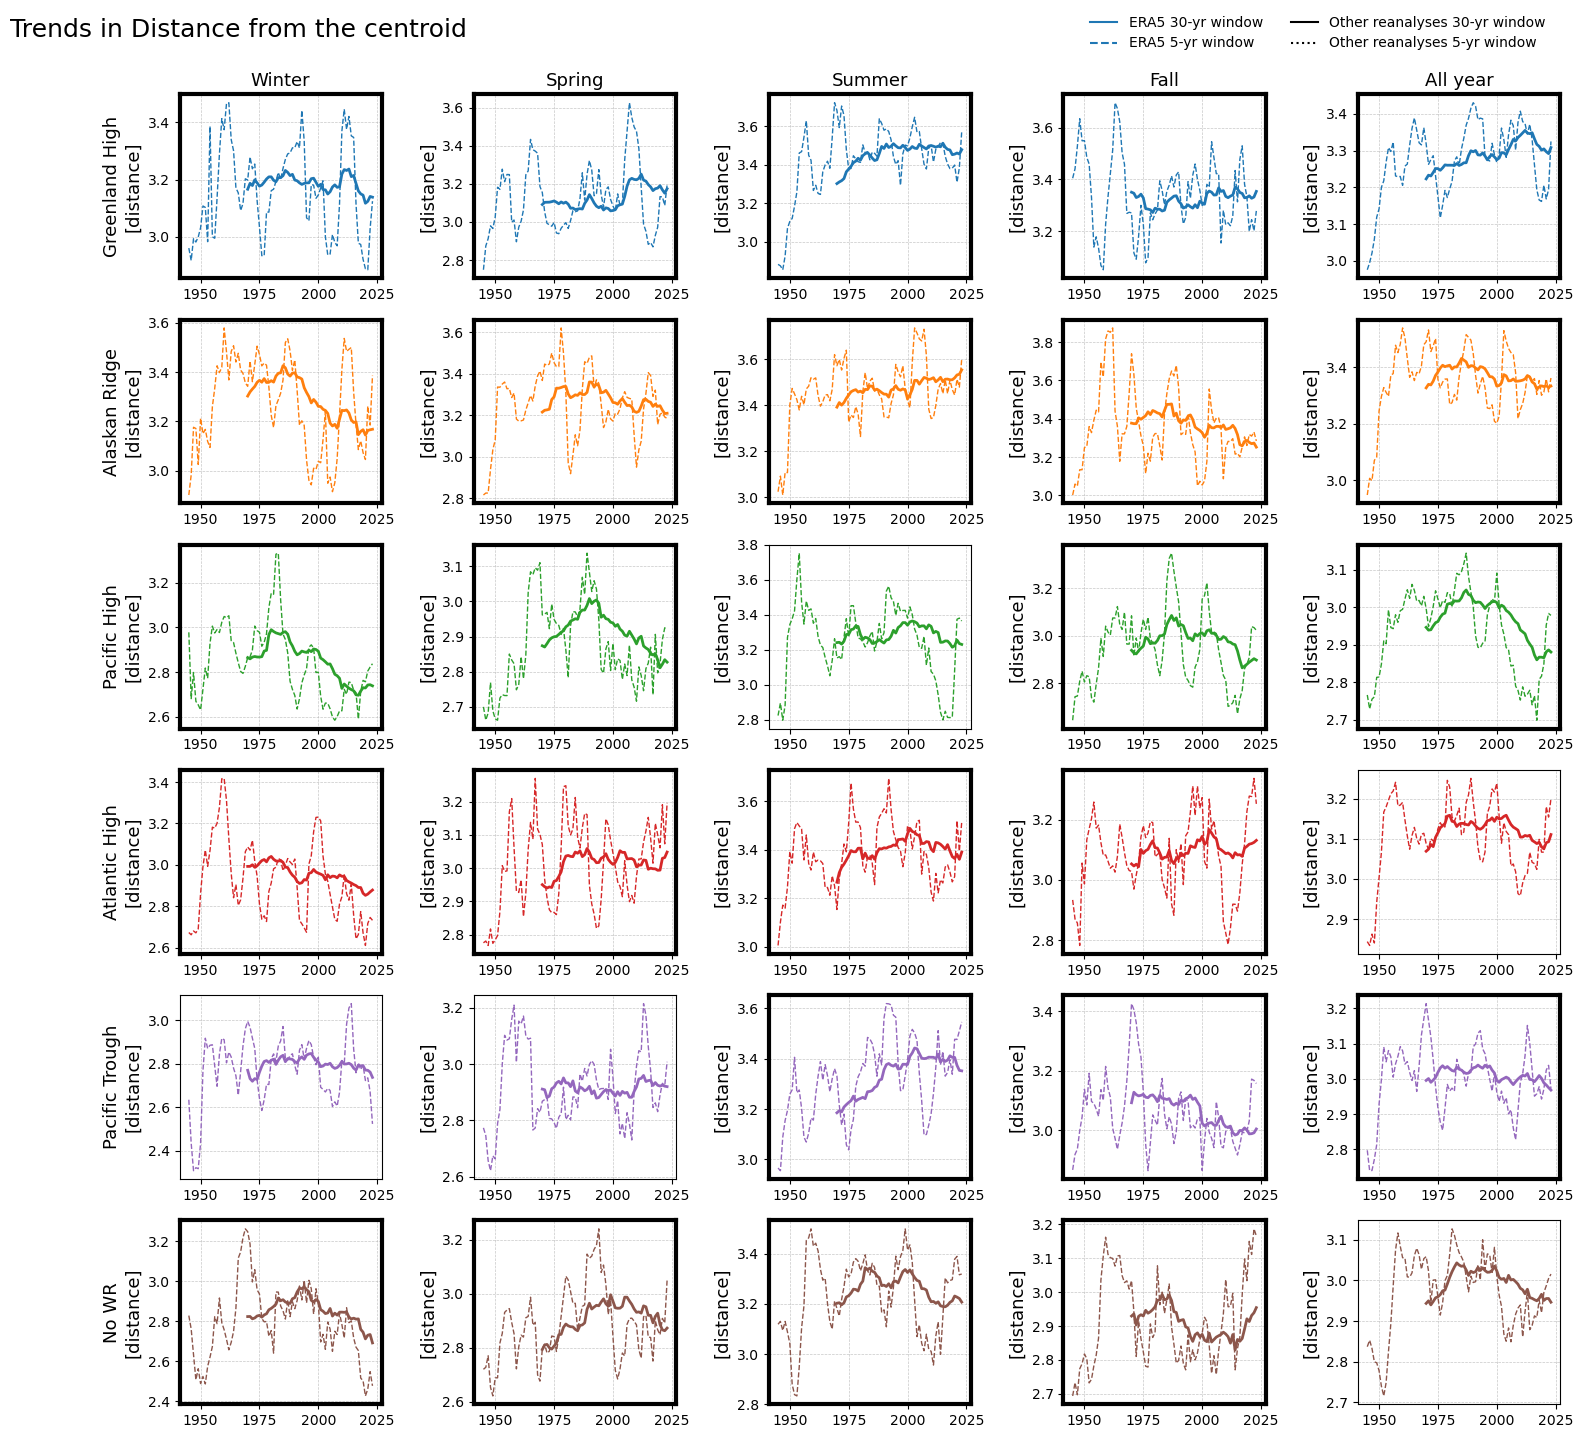

In [26]:
import matplotlib.lines as mlines

reanalysis = 'ERA5'
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
season_titles = ['Winter', 'Spring', 'Summer', 'Fall', 'All year']

fig, axes = plt.subplots(nrows=len(names_wrs), ncols=5, figsize=(15, 15))  # Adjust figsize to accommodate more subplots
axes = axes.flatten()

# Iterate over each weather regime (rows)
for wr in range(len(names_wrs)):
    # Iterate over each season (columns)
    for iseason, season in enumerate(['Winter', 'Spring', 'Summer', 'Fall', 'all']):
        ax = axes[wr * 5 + iseason]

        # Plot ERA5 data with solid lines
        df_temp_30 = dics_distances_30['ERA5'][season][[wr]]
        df_temp_5 = dics_distances_5['ERA5'][season][[wr]]
        approval30 = compute_significance_approval_30(df_temp_30, n)
        approval5 = compute_significance_approval_5(df_temp_5, n)
        ls = 'solid'
        if approval30:
            for spine in ax.spines.values():
                spine.set_linewidth(3)  # Set the thickness of the border (default is 1)
        ax.plot(df_temp_30, color=colors[wr], ls=ls, zorder=10, lw=2)
        ax.plot(df_temp_5, color=colors[wr], ls='dashed', zorder=10, lw=1)
        # Plot other reanalyses with dashed lines if significance is approved
        for reanalysis in names_reanalyses[1:-2]:
            df_temp_5 = dics_distances_5[reanalysis][season][[wr]]
            df_temp_30 = dics_distances_30[reanalysis][season][[wr]]
            ax.plot(df_temp_5, color='k', ls='dotted', zorder=0, lw=1.5)
            ax.plot(df_temp_30, color='k', ls='solid', zorder=0, lw=2)
        # else:
        #     ax.plot(df_temp_30, color=colors[wr], ls=ls, zorder=10, lw=1,alpha=0.7)
        #     ax.plot(df_temp_5, color=colors[wr], ls='dashed', zorder=10, lw=1,alpha=0.7)
            # Plot other reanalyses with dashed lines if significance is approved
        # Set the title for each season column (first row only)
        if wr == 0:
            ax.set_title(season_titles[iseason], fontsize=13)
        
        # Set y-axis label for the first column in each row
        if iseason == 0:
            ax.set_ylabel(f'{names_wrs[wr]}\n[distance]', fontsize=13)
        else:
            ax.set_ylabel(f'[distance]', fontsize=13)

        # Add transparent gridlines
        ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

        # Set font sizes for axes labels
        ax.tick_params(axis='both', which='major', labelsize=10)

# Add a main title to the entire plot
fig.suptitle("Trends in Distance from the centroid", fontsize=18, y=0.95, x=0.1)

# Adjust layout to prevent overlapping
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Create custom legend handles for the top-right corner
legend_lines = [
    mlines.Line2D([], [], color=colors[0], linestyle='solid', label='ERA5 30-yr window'),
    mlines.Line2D([], [], color=colors[0], linestyle='dashed', label='ERA5 5-yr window'),
    mlines.Line2D([], [], color='k', linestyle='solid', label='Other reanalyses 30-yr window'),
    mlines.Line2D([], [], color='k', linestyle='dotted', label='Other reanalyses 5-yr window')
]

# Add the legend to the top right of the figure
fig.legend(handles=legend_lines,ncol=2, loc='upper right', bbox_to_anchor=(0.98, 0.96), fontsize=10, frameon=False)

plt.savefig('../Figures_v3/TrendsWRs_Reanalysis/DistanceTrends.png')

# Correlation time series

In [27]:
def extract_region(data_array, regioncoords):
    """
    Extract a region from a DataArray with longitudes ranging from 0 to 360.
    Rearrange the data to have continuous longitudes even if the region wraps around 0 or 360 degrees.
    
    Parameters:
    data_array (xr.DataArray): Input DataArray with coordinates 'lon' (0 to 360) and 'lat'.
    min_lon (float): Minimum longitude of the region.
    max_lon (float): Maximum longitude of the region.
    min_lat (float): Minimum latitude of the region.
    max_lat (float): Maximum latitude of the region.
    
    Returns:
    xr.DataArray: Extracted region with continuous coordinates.
    """
    min_lon, max_lon, min_lat, max_lat = regioncoords

    # Handle the case where the region crosses the prime meridian or the International Date Line
    if min_lon > max_lon:
        # Split the region into two parts: one on the left of 0° and one on the right
        region1 = data_array.sel(
            lon=slice(min_lon, 360), 
            lat=slice(min_lat, max_lat)
        )
        region2 = data_array.sel(
            lon=slice(0, max_lon), 
            lat=slice(min_lat, max_lat)
        )

        # Combine the two parts along the longitude axis
        combined_region = xr.concat([region1, region2], dim='lon')

    else:
        # Directly slice the region
        combined_region = data_array.sel(
            lon=slice(min_lon, max_lon), 
            lat=slice(min_lat, max_lat)
        )

    # # Sort the longitudes to ensure they are in the correct order
    # combined_region = combined_region.sortby('lon')

    return combined_region


## compute seasonal composites and correlations

In [28]:
import xarray as xr
import numpy as np

def get_average_fields_for_centroids(dataarray, labels):
    """
    Compute average fields for each weather regime (WR) and season.
    
    Parameters:
    - dataarray (xarray.DataArray): The input data array with a 'time' dimension.
    - labels (pd.DataFrame): A DataFrame containing 'WR' and 'season' columns, where index is the time.
    
    Returns:
    - xarray.Dataset: A dataset with dimensions ('WR', 'season', 'lat', 'lon') containing the average fields.
    """
    # Define the seasons
    seasons = ['Winter', 'Spring', 'Summer', 'Fall', 'all']
    
    # Unique weather regimes
    wrs = np.unique(labels['WR'])
    
    # Create an empty list to hold the average fields for each WR and season
    avg_fields = []

    # Loop through each WR
    for wr in wrs:
        # print(wr)
        # Create an empty list to hold the average fields for each season within a WR
        wr_fields = []
        for season in seasons:
            # print(season)
            if season == 'all':
                # Select rows for the current WR across all seasons
                df_wr = labels[labels['WR'] == wr]
            else:
                # Select rows for the current WR and season
                df_wr = labels[(labels['WR'] == wr) & (labels['season'] == season)]

            # Select the corresponding time indices in the dataarray
            arr_selection = dataarray.sel(time=df_wr.index)

            # Calculate the mean over time dimension
            averagefield = arr_selection.mean('time')
            
            # Append to the list for the current WR
            wr_fields.append(averagefield)
        
        # Concatenate along the 'season' dimension (length 5) for the current WR
        avg_fields.append(xr.concat(wr_fields, dim='season'))

    # Create a new coordinate for WRs and assign values
    wr_coord = xr.DataArray(wrs, dims='WR', name='WR')

    # Combine the results into a single xarray Dataset
    avg_dataset = xr.concat(avg_fields, dim=wr_coord)

    # Assign season names to the 'season' dimension
    avg_dataset = avg_dataset.assign_coords(season=('season', seasons))

    return avg_dataset

In [29]:
path_anoms = '/glade/derecho/scratch/jhayron/Data4WRsClimateChange/ProcessedDataReanalyses/'

In [30]:
for reanalysis in names_reanalyses:
    anoms = xr.open_dataset(f'{path_anoms}Z500FiltAnoms_{reanalysis}_v3.nc')
    region = [180, 330, 20, 80]
    data_region = extract_region(anoms, region)
    composites = get_average_fields_for_centroids(anoms, dic_labels[reanalysis])
    composites.to_netcdf(f'../Data_v3/Composites/CompositesSeasonal_{reanalysis}_v3.nc')

In [31]:
dic_composites = {}

for reanalysis in names_reanalyses:
    composites = xr.open_dataset(f'../Data_v3/Composites/CompositesSeasonal_{reanalysis}_v3.nc')
    dic_composites[reanalysis] = composites

In [33]:
# Iterate over each weather regime (rows)
for reanalysis in names_reanalyses:
    anoms = xr.open_dataset(f'{path_anoms}Z500FiltAnoms_{reanalysis}_v3.nc')
    region = [180, 330, 20, 80]
    data_region = extract_region(anoms, region)
    corrs = []
    for itime in range(len(dic_labels[reanalysis])):
        map_temp = data_region.sel(time = dic_labels[reanalysis].index[itime]).Z_anomalies
        wr_temp = dic_labels[reanalysis].iloc[itime]['WR']
        season_temp = dic_labels[reanalysis].iloc[itime]['season']
        comp_temp = dic_composites[reanalysis].sel(WR=wr_temp,season=season_temp,
                                   lat=map_temp.lat,lon=map_temp.lon).Z_anomalies
        corr = np.corrcoef(map_temp.values.ravel(),comp_temp.values.ravel())[0,1]
        corrs.append(corr)
    dic_labels[reanalysis]['corrs'] = corrs

In [34]:
for reanalysis in names_reanalyses:
    dic_labels[reanalysis].to_csv(f'../Data_v3/Labels/df_labels_extra_{reanalysis}_v3.csv')

In [35]:
dic_labels = {}
for reanalysis in names_reanalyses:
    dic_labels[reanalysis] = pd.read_csv(f'../Data_v3/Labels/df_labels_extra_{reanalysis}_v3.csv'
                ,index_col=0,parse_dates=True)

In [36]:
def get_mean_corr_labels(df_labels_temp):
    overall_corr = df_labels_temp.groupby('WR').mean()['corrs']
    seasonal_corr = df_labels_temp.groupby(['season', 'WR']).mean().unstack(fill_value=0)['corrs']
    return overall_corr,seasonal_corr
    
def get_time_series_of_corrs(df_labels, N=30):
    dict_labels = extract_n_years_around_each_year(df_labels, N)
    years_trends = df_labels.index.year.unique()[N:]
    seasons = ['Winter', 'Spring', 'Summer', 'Fall']
    
    series_corrs = []
    series_corrs_seasonal = {}
    for season in seasons:
        series_corrs_seasonal[season] = []
    
    for year in years_trends:
        series_corrs.append(get_mean_corr_labels(dict_labels[year])[0].values)
        for season in seasons:
            series_corrs_seasonal[season].append(get_mean_corr_labels(dict_labels[year])[1].loc[season])
    
    series_corrs = np.array(series_corrs)
    for season in seasons:
        series_corrs_seasonal[season] = pd.DataFrame(np.array(series_corrs_seasonal[season]), index = years_trends)
    series_corrs_seasonal['all'] = pd.DataFrame(series_corrs, index = years_trends)
    return series_corrs_seasonal

In [37]:
dics_corrs_30 = {}
n = 30

for reanalysis in names_reanalyses[:3]:
    dics_corrs_30[reanalysis] = get_time_series_of_corrs(dic_labels[reanalysis],n)

dics_corrs_5 = {}
n = 5

for reanalysis in names_reanalyses[:3]:
    dics_corrs_5[reanalysis] = get_time_series_of_corrs(dic_labels[reanalysis],n)

dics_corrs_3 = {}
n = 3

for reanalysis in names_reanalyses[:3]:
    dics_corrs_3[reanalysis] = get_time_series_of_corrs(dic_labels[reanalysis],n)


In [38]:
# Iterate over each weather regime (rows)
for wr in range(7):
    # Iterate over each season (columns)
    print('-------------')
    print(wr)
    print('-------------')
    for iseason, season in enumerate(['Winter', 'Spring', 'Summer', 'Fall', 'all']):
        print(wr,season)
        print(mann_kendall_sen_slope(dics_corrs_30['ERA5'][season][wr].loc['1979':].values)['Mann-Kendall Test']['Trend'])
        print(mann_kendall_sen_slope(dics_corrs_30['JRA3Q'][season][wr].loc['1979':].values)['Mann-Kendall Test']['Trend'])
        print(mann_kendall_sen_slope(dics_corrs_30['NCEP_NCAR'][season][wr].loc['1979':].values)['Mann-Kendall Test']['Trend'])
        # print(mann_kendall_sen_slope(dics_durations_30['ERA5'][season][wr].loc[1979+15:].values)['Mann-Kendall Test']['Trend'])

-------------
0
-------------
0 Winter
no trend
decreasing
decreasing
0 Spring
decreasing
decreasing
decreasing
0 Summer
decreasing
decreasing
decreasing
0 Fall
no trend
no trend
no trend
0 all
decreasing
decreasing
decreasing
-------------
1
-------------
1 Winter
no trend
no trend
no trend
1 Spring
increasing
increasing
increasing
1 Summer
increasing
increasing
increasing
1 Fall
no trend
no trend
no trend
1 all
increasing
increasing
increasing
-------------
2
-------------
2 Winter
increasing
increasing
increasing
2 Spring
no trend
no trend
no trend
2 Summer
no trend
no trend
decreasing
2 Fall
increasing
increasing
increasing
2 all
increasing
increasing
increasing
-------------
3
-------------
3 Winter
decreasing
decreasing
no trend
3 Spring
no trend
no trend
no trend
3 Summer
decreasing
decreasing
decreasing
3 Fall
decreasing
decreasing
decreasing
3 all
decreasing
decreasing
decreasing
-------------
4
-------------
4 Winter
increasing
increasing
increasing
4 Spring
decreasing
decrea

KeyError: 6

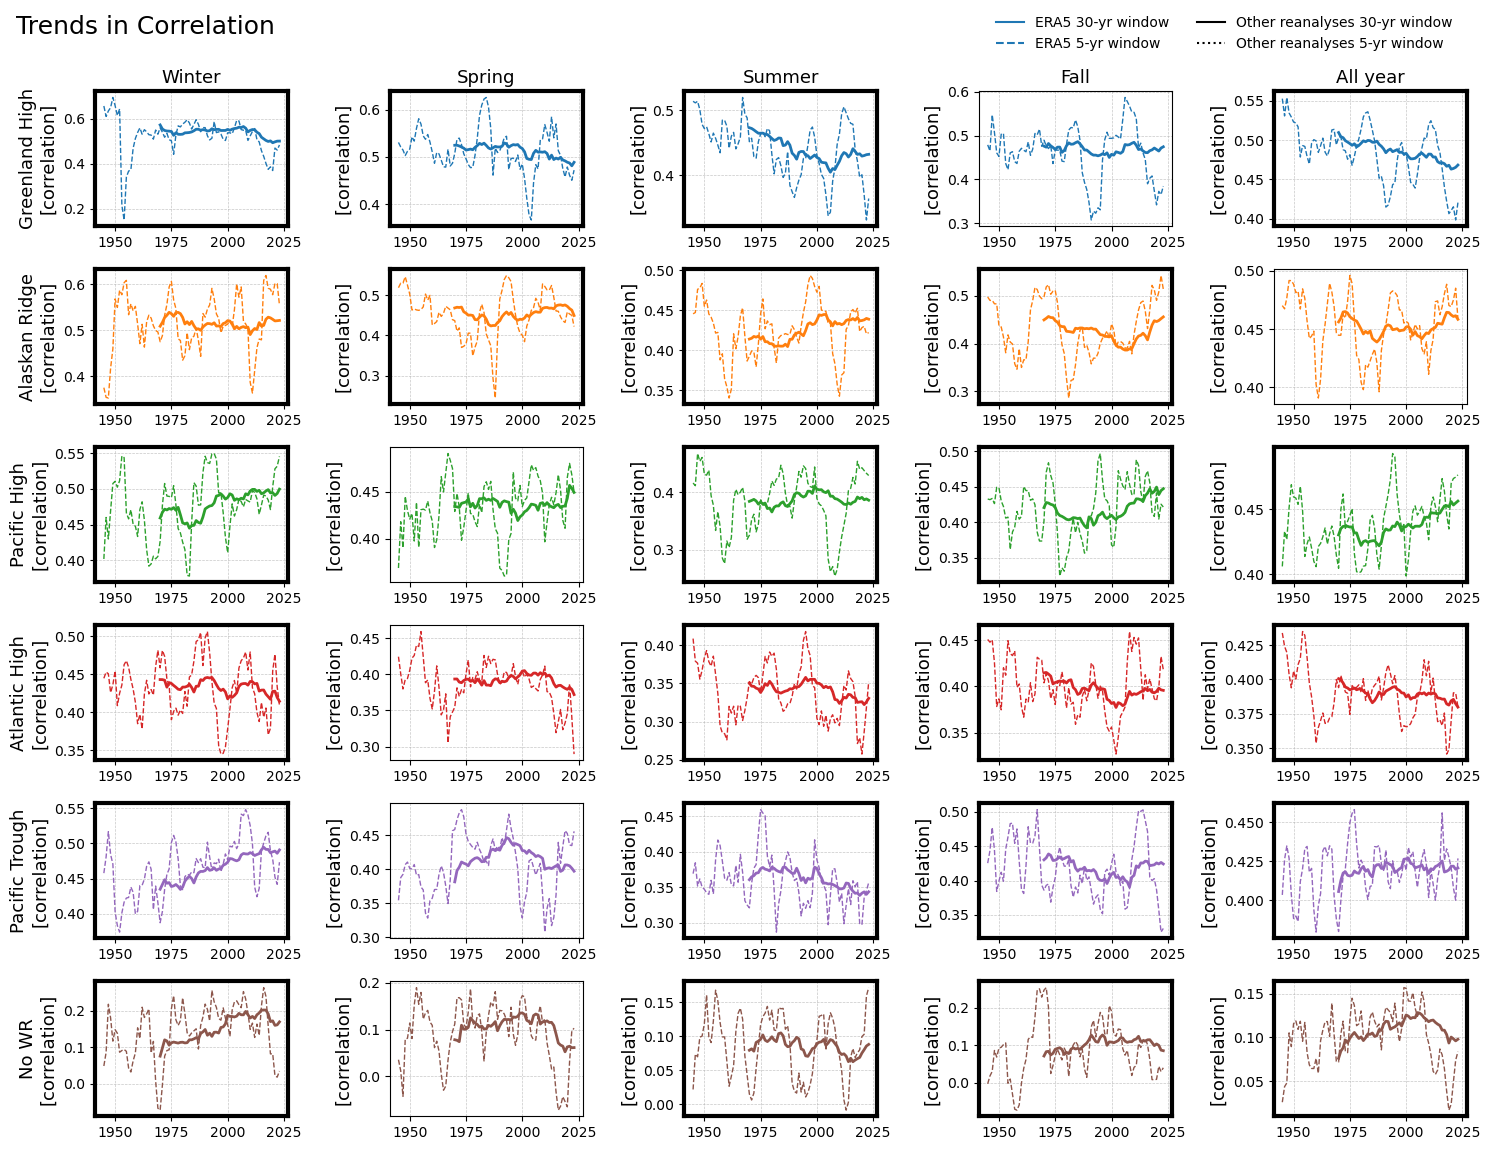

In [39]:
import matplotlib.lines as mlines

reanalysis = 'ERA5'
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
season_titles = ['Winter', 'Spring', 'Summer', 'Fall', 'All year']

fig, axes = plt.subplots(nrows=len(names_wrs), ncols=5, figsize=(15, 12))  # Adjust figsize to accommodate more subplots
axes = axes.flatten()

# Iterate over each weather regime (rows)
for wr in range(len(names_wrs)):
    # Iterate over each season (columns)
    for iseason, season in enumerate(['Winter', 'Spring', 'Summer', 'Fall', 'all']):
        ax = axes[wr * 5 + iseason]

        # Plot ERA5 data with solid lines
        df_temp_30 = dics_corrs_30['ERA5'][season][[wr]]
        df_temp_5 = dics_corrs_5['ERA5'][season][[wr]]
        approval30 = compute_significance_approval_30(df_temp_30, n)
        approval5 = compute_significance_approval_5(df_temp_5, n)
        ls = 'solid'
        if approval30:
            for spine in ax.spines.values():
                spine.set_linewidth(3)  # Set the thickness of the border (default is 1)
        ax.plot(df_temp_30, color=colors[wr], ls=ls, zorder=10, lw=2)
        ax.plot(df_temp_5, color=colors[wr], ls='dashed', zorder=10, lw=1)
        # Plot other reanalyses with dashed lines if significance is approved
        for reanalysis in names_reanalyses[1:-2]:
            df_temp_5 = dics_corrs_5[reanalysis][season][[wr]]
            df_temp_30 = dics_corrs_30[reanalysis][season][[wr]]
            ax.plot(df_temp_5, color='k', ls='dotted', zorder=0, lw=1.5)
            ax.plot(df_temp_30, color='k', ls='solid', zorder=0, lw=2)
        # else:
        #     ax.plot(df_temp_30, color=colors[wr], ls=ls, zorder=10, lw=1,alpha=0.7)
        #     ax.plot(df_temp_5, color=colors[wr], ls='dashed', zorder=10, lw=1,alpha=0.7)
            # Plot other reanalyses with dashed lines if significance is approved
        # Set the title for each season column (first row only)
        if wr == 0:
            ax.set_title(season_titles[iseason], fontsize=13)
        
        # Set y-axis label for the first column in each row
        if iseason == 0:
            ax.set_ylabel(f'{names_wrs[wr]}\n[correlation]', fontsize=13)
        else:
            ax.set_ylabel(f'[correlation]', fontsize=13)

        # Add transparent gridlines
        ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

        # Set font sizes for axes labels
        ax.tick_params(axis='both', which='major', labelsize=10)

# Add a main title to the entire plot
fig.suptitle("Trends in Correlation", fontsize=18, y=0.95, x=0.1)

# Adjust layout to prevent overlapping
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Create custom legend handles for the top-right corner
legend_lines = [
    mlines.Line2D([], [], color=colors[0], linestyle='solid', label='ERA5 30-yr window'),
    mlines.Line2D([], [], color=colors[0], linestyle='dashed', label='ERA5 5-yr window'),
    mlines.Line2D([], [], color='k', linestyle='solid', label='Other reanalyses 30-yr window'),
    mlines.Line2D([], [], color='k', linestyle='dotted', label='Other reanalyses 5-yr window')
]

# Add the legend to the top right of the figure
fig.legend(handles=legend_lines,ncol=2, loc='upper right', bbox_to_anchor=(0.98, 0.96), fontsize=10, frameon=False)

plt.savefig('../Figures_v3/CorrTrends_v3.png')